In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg

import sys
sys.path.insert(0,'..')
import specsens as ss

   infs left at  0.00%
 76.07s left at  0.33%
 74.21s left at  0.67%
 73.38s left at  1.00%
 73.41s left at  1.33%
 75.45s left at  1.67%
 71.44s left at  2.00%
 71.92s left at  2.33%
 72.26s left at  2.67%
 73.10s left at  3.00%
 71.28s left at  3.33%
 71.04s left at  3.67%
 72.18s left at  4.00%
 72.33s left at  4.33%
 70.34s left at  4.67%
 73.26s left at  5.00%
 75.46s left at  5.33%
 74.45s left at  5.67%
 68.37s left at  6.00%
 71.14s left at  6.33%
 72.62s left at  6.67%
 70.21s left at  7.00%
 67.42s left at  7.33%
 67.99s left at  7.67%
 69.33s left at  8.00%
 69.80s left at  8.33%
 66.39s left at  8.67%
 66.82s left at  9.00%
 65.60s left at  9.33%
 66.10s left at  9.67%
 66.70s left at 10.00%
 66.71s left at 10.33%
 66.36s left at 10.67%
 67.32s left at 11.00%
 64.73s left at 11.33%
 67.73s left at 11.67%
 70.00s left at 12.00%
 69.44s left at 12.33%
 67.76s left at 12.67%
 68.10s left at 13.00%
 67.22s left at 13.33%
 65.64s left at 13.67%
 65.75s left at 14.00%
 66.64s lef

/home/fabian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in double_scalars


 28.02s left at 62.67%
 27.91s left at 63.00%
 27.08s left at 63.33%
 27.09s left at 63.67%
 26.69s left at 64.00%
 26.11s left at 64.33%
 25.54s left at 64.67%
 25.74s left at 65.00%
 27.30s left at 65.33%
 25.05s left at 65.67%
 24.44s left at 66.00%
 24.70s left at 66.33%
 24.12s left at 66.67%
 24.09s left at 67.00%
 23.51s left at 67.33%
 23.23s left at 67.67%
 23.38s left at 68.00%
 23.02s left at 68.33%
 22.67s left at 68.67%
 22.54s left at 69.00%
 22.15s left at 69.33%
 22.32s left at 69.67%
 22.05s left at 70.00%
 21.84s left at 70.33%
 21.14s left at 70.67%
 20.92s left at 71.00%
 20.70s left at 71.33%
 20.42s left at 71.67%
 20.08s left at 72.00%
 20.00s left at 72.33%
 20.01s left at 72.67%
 19.74s left at 73.00%
 19.80s left at 73.33%
 19.35s left at 73.67%
 18.87s left at 74.00%
 18.38s left at 74.33%
 18.38s left at 74.67%
 18.04s left at 75.00%
 17.82s left at 75.33%
 17.96s left at 75.67%
 17.67s left at 76.00%
 17.53s left at 76.33%
 17.30s left at 76.67%
 16.93s lef

/home/fabian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in double_scalars


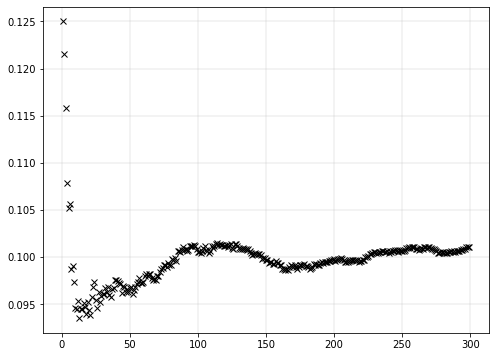

Theory     pfa 0.1
Simulation pfa 0.10102548086789448
Theory     pd  0.9577161904482208
Simulation pd  0.9614784139605748


In [75]:
import time

class MonteCarloSim():
    def __init__(self, gens, itrs):
        self.gens = gens  # Number of generations
        self.itrs = itrs  # NUmber of iterations per generation
        self.reset()

    def reset(self):
        self.pfas = list()  # Probability of false alarm list
        self.pds = list()  # Probability of detection list
        self.time = None

    def run(self,
            signal_strength=0.,
            noise_strength=0.,
            sample_freq=1e6,
            length=1.,
            pre_pfa=0.1):
        
        self.reset()
        n = 1024
        thr = ss.chi2_stats.get_thr(
            noise_power=ss.util.dB_to_factor_power(noise_strength),
            pfa=pre_pfa,
#             n=ss.util.get_signal_length(f_sample=sample_freq, t_sec=length))
            n=1024)
        length = ss.util.sample_time(f_sample=sample_freq, num_samples=n)
            
        super_ratio1 = list()
        super_ratio2 = list()
        super_ratio3 = list()
        super_ratio4 = list()
        
        for i in range(self.gens):
            wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length)
            wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)

            correct_hit = 0
            false_hit = 0
            correct_miss = 0
            false_miss = 0
            times_signal_present = 0

#             noise_uncertainty = np.random.uniform(-1., 1.)
            noise_uncertainty = 0.
    
            ratio_list1 = list()
            ratio_list2 = list()
            ratio_list3 = list()
            ratio_list4 = list()

            for j in range(self.itrs):
                sig = wm.get_soft(f_center=1e5, dB=signal_strength)
                noise = wgn.get_signal(dB=noise_strength + noise_uncertainty)

                sig_present = bool(np.random.randint(2))
                if sig_present:
                    both = sig + noise
                    times_signal_present += 1
                else:
                    both = noise

                eng = ss.EnergyDetector.get(both)

                sft = ss.Stft(n=1024, window='flattop')
                f, t, x = sft.spectogram(sig=both, f_sample=sample_freq, normalized=False, dB=False)
                psd = x[:, 0]
                
                
#                 from scipy import fft
#                 f_welch, x_welch = signal.welch(both,
#                                                 sample_freq,
#                                                 nperseg=1024,
#                                                 noverlap=0,
#                                                 window='flattop',
#                                                 scaling='density',
#                                                 detrend=False,
#                                                 return_onesided=False)
#                 f = fft.fftshift(f_welch)
#                 psd = fft.fftshift(x_welch) * sample_freq
                
                
#                 plt.figure(figsize=(8, 6))
#                 plt.semilogy(f, psd)
#                 plt.show()

#                 edf = ss.FreqEnergyDetector(num_bands=1, f_sample=1e6, fft_len=1024, freqs=f)
#                 eng_freq = edf.detect(psd)[0]

#                 eng_freq = ss.util.get_energy_from_psd(psd) / 1.003
                
                eng_freq = ss.util.get_energy_from_psd(psd)

#                 print(f'eng time: {eng}, eng freq: {eng_freq}, ratio: {eng/(edf.detect(psd)[0]+edf.detect(psd)[1])}, thr: {thr}')
#                 print(f'eng time: {eng}, eng freq: {eng_freq}, thr: {thr}')
                
#                 ratio_list.append(eng/(edf.detect(psd)[0]+edf.detect(psd)[1]))
#                 ratio_list.append(eng/(edf.detect(psd)[0]))
#                 if not sig_present:
#                     ratio_list.append(eng/eng_freq)
    
                sig_detected = eng > thr

                if sig_present and sig_detected:
                    correct_hit += 1
                    ratio_list1.append(eng/eng_freq)
                elif sig_present and not sig_detected:
                    false_miss += 1
                    ratio_list2.append(eng/eng_freq)
                elif not sig_present and sig_detected:
                    false_hit += 1
                    ratio_list3.append(eng/eng_freq)
                else:
                    correct_miss += 1
                    ratio_list4.append(eng/eng_freq)
            
#             ratio = np.sum(ratio_list)/self.itrs
#             ratio = np.sum(ratio_list)/(self.itrs - times_signal_present)
            ratio1 = np.sum(ratio_list1)/(correct_hit)
            ratio2 = np.sum(ratio_list2)/(false_miss)
            ratio3 = np.sum(ratio_list3)/(false_hit)
            ratio4 = np.sum(ratio_list4)/(correct_miss)
            
            super_ratio1.append(ratio1)
            super_ratio2.append(ratio2)
            super_ratio3.append(ratio3)
            super_ratio4.append(ratio4)
            
            pfa_tmp = false_hit / (self.itrs - times_signal_present)
            pd_tmp = correct_hit / times_signal_present
            self.pfas.append(pfa_tmp)
            self.pds.append(pd_tmp)
            rem, per = self.runtime_stats(self.gens, i)
#             print('%6.2fs left at %5.2f%%   ratio: %f' % (rem, per, ratio))
            print('%6.2fs left at %5.2f%%' % (rem, per))
        
        print(f'super_ratio1: {np.sum(super_ratio1)/self.gens}')
        print(f'super_ratio2: {np.sum(super_ratio2)/self.gens}')
        print(f'super_ratio3: {np.sum(super_ratio3)/self.gens}')
        print(f'super_ratio4: {np.sum(super_ratio4)/self.gens}')
        
        pfa = np.sum(self.pfas) / self.gens
        pd = np.sum(self.pds) / self.gens
        return pfa, pd

    def runtime_stats(self, total_itr, current_itr):
        if self.time is None:
            self.time = time.time()
            return float('inf'), 0.0
        delta_time = time.time() - self.time
        self.time = time.time()
        remaining_itr = total_itr - current_itr
        remaining_time = delta_time * remaining_itr
        percent_done = current_itr / total_itr * 100.0
        return remaining_time, percent_done

    def print_convergence(self):
        plt.figure(figsize=(8, 6))
        plt.grid(linewidth=0.3)
        for i in range(self.gens):
            inter = np.sum(self.pfas[0:i]) / i
            plt.plot(i, inter, 'kx')
        plt.show()


sim = MonteCarloSim(300, 300)
pfa, pd = sim.run(signal_strength=0.,
                  noise_strength=10.,
                  sample_freq=1e6,
                  length=0.002,
                  pre_pfa=0.1)


sim.print_convergence()

print(f'Theory     pfa {0.1}')
print(f'Simulation pfa {pfa}')
print(f'Theory     pd  {ss.chi2_stats.get_pd(ss.util.dB_to_factor_power(10.), ss.util.dB_to_factor_power(0.), ss.chi2_stats.get_thr(10., 0.1, ss.util.get_signal_length(f_sample=1e6, t_sec=0.001)), ss.util.get_signal_length(f_sample=1e6, t_sec=0.001))}')
print(f'Simulation pd  {pd}')